In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import rawpy

def load_images(image_paths):
    images = [cv2.imread(image_path) for image_path in image_paths]
    return images

def compute_response_curve(images, exposures, smoothing_lambda=100.0):
    # Compute radiometric response curve using Debevec method
    # images: List of images (grayscale)
    # exposures: List of exposure times for each image
    # smoothing_lambda: Lambda parameter for smoothing

    images = [np.float64(img) / 255.0 for img in images]

    response = cv2.createCalibrateDebevec()
    response.process(images, exposures, response)

    return response.getMat()

def compute_hdr_image(images, exposures, response_curve):
    # Compute HDR image using Debevec method
    # images: List of images (grayscale)
    # exposures: List of exposure times for each image
    # response_curve: Radiometric response curve

    images = [np.float64(img) / 255.0 for img in images]

    hdr = cv2.createMergeDebevec()
    hdr.process(images, response_curve, exposures)

    return hdr.getMat()

def interactive_exposure_adjustment(image):
    # Interactive exposure adjustment using a simple linear scaling
    # image: Input image

    exposure = 1.0  # Default exposure value

    while True:
        plt.imshow(image * exposure)
        plt.title(f"Exposure: {exposure}")
        plt.show()

        key = input("Press 'q' to quit, 'a' to increase exposure, 's' to decrease exposure: ")

        if key == 'q':
            break
        elif key == 'a':
            exposure *= 1.1
        elif key == 's':
            exposure /= 1.1

    plt.close()

def tone_mapping(hdr_image):
    # Simple global tone mapping using Reinhard's method
    tonemap = cv2.createTonemapReinhard()
    tonemapped_image = tonemap.process(hdr_image)

    # Clip values to the displayable range [0, 1]
    tonemapped_image = np.clip(tonemapped_image, 0, 1)

    return (tonemapped_image * 255).astype(np.uint8)

if __name__ == "__main__":
    # Paths to your images
    jpg_paths = ["image_1.jpg", "image_2.jpg", "image_3.jpg", "image_4.jpg"]
    raw_paths = ["raw_image_1.raw", "raw_image_2.raw", "raw_image_3.raw", "raw_image_4.raw"]
    jpeg_paths = ["jpeg_image_1.jpg", "jpeg_image_2.jpg", "jpeg_image_3.jpg", "jpeg_image_4.jpg"]

    # Load images
    jpg_images = load_images(jpg_paths)
    raw_images = [rawpy.imread(raw_path).postprocess() for raw_path in raw_paths]
    jpeg_images = load_images(jpeg_paths)

    # Exposure times (in seconds) - example values
    exposures = [1.0 / 60, 1.0 / 250, 1.0 / 1000]

    # Step 3: Estimate radiometric response function
    response_curve = compute_response_curve(jpg_images, exposures)

    # Step 4: Estimate high dynamic range radiance image
    hdr_image = compute_hdr_image(jpg_images, exposures, response_curve)

    # Step 6: Calibrate RAW and JPEG images simultaneously
    # Placeholder, replace with your implementation
    # ...

    # Step 7: Develop an interactive viewer to change image exposure
    interactive_exposure_adjustment(jpg_images[0])

    # Step 8: Implement a tone mapping operator
    tonemapped_image = tone_mapping(hdr_image)

    # Display results using Matplotlib
    plt.figure(figsize=(12, 6))

    plt.subplot(131)
    plt.imshow(jpg_images[1])
    plt.title("Original Image")

    plt.subplot(132)
    plt.imshow(hdr_image)
    plt.title("HDR Image")

    plt.subplot(133)
    plt.imshow(tonemapped_image)
    plt.title("Tonemapped Image")

    plt.show()


LibRawFileUnsupportedError: b'Unsupported file format or not RAW file'

Text(0.5, 1.0, 'Original Image')

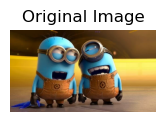

In [6]:
jpg_paths = ["image_1.jpg", "image_2.jpg", "image_3.jpg", "image_4.jpg"]
jpg_images = load_images(jpg_paths)
plt.subplot(131)
plt.imshow(jpg_images[1])
plt.axis("off")
plt.title("Original Image")

Text(0.5, 1.0, 'raw one')

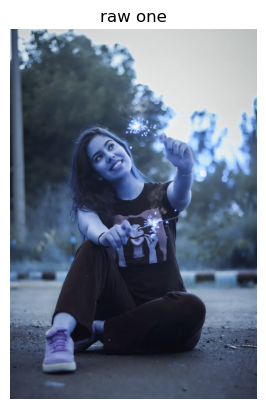

In [7]:
raw_paths = ["raw_image_1.raw", "raw_image_2.raw", "raw_image_3.raw", "raw_image_4.raw"]
raw_images = load_images(raw_paths)
plt.imshow(raw_images[1])
plt.axis("off")
plt.title("raw one")

In [11]:
import cv2
import numpy as np

def align_images(images):
    orb = cv2.ORB_create()
    keypoints1, descriptors1 = orb.detectAndCompute(images[0], None)

    aligned_images = [images[0]]

    for i in range(1, len(images)):
        keypoints2, descriptors2 = orb.detectAndCompute(images[i], None)

        # Use a feature matching algorithm (e.g., BFMatcher) to find matches
        bf = cv2.BFMatcher()
        matches = bf.knnMatch(descriptors1, descriptors2, k=2)

        # Apply ratio test
        good_matches = []
        for m, n in matches:
            if m.distance < 0.75 * n.distance:
                good_matches.append(m)

        # Check if there are enough good matches for homography calculation
        if len(good_matches) >= 4:
            # Get corresponding points
            src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
            dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

            # Use findHomography with RANSAC to get the transformation matrix
            h, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC)

            # Warp the image
            aligned_image = cv2.warpPerspective(images[i], h, (images[i].shape[1], images[i].shape[0]))
            aligned_images.append(aligned_image)
        else:
            print(f"Warning: Not enough matches for image {i}. Consider capturing more overlapping images.")

    return aligned_images


def estimate_response_function(images, exposures, smoothing_lambda=100.0):
    num_images = len(images)
    num_intensity_values = 256
    Z = np.zeros((num_images, num_intensity_values), dtype=np.uint8)
    ln_t = np.log(exposures)

    for i in range(num_images):
        for j in range(num_intensity_values):
            Z[i, j] = np.clip(images[i][(images[i] >= j) & (images[i] < j + 1)].mean(), 0, 255)

    A, B = np.zeros(num_intensity_values), np.zeros(num_intensity_values)

    for i in range(num_intensity_values):
        valid_indices = Z[:, i] > 0
        Zij = Z[valid_indices, i]
        ln_Eij = ln_t[valid_indices]  # Use boolean indexing directly
        weights = np.exp(-((Zij - 127) ** 2) / (2 * smoothing_lambda ** 2))

        A[i] = np.sum(weights * ln_Eij) / np.sum(weights)
        B[i] = np.sum(weights) / np.sum(weights * (ln_Eij - A[i]))

    return A, B




def create_hdr_image(images, response_curve, exposures):
    # Combine images to create HDR radiance map
    num_images = len(images)
    hdr_image = np.zeros_like(images[0], dtype=np.float32)
    ln_t = np.log(exposures)

    for i in range(num_images):
        scaled_image = np.exp((response_curve[images[i]] - ln_t[i]))
        hdr_image += scaled_image

    hdr_image /= num_images

    return hdr_image

def tone_mapping_operator(hdr_image):
    # Placeholder for tone mapping (simple gamma correction)
    tone_mapped_image = np.clip(hdr_image, 0, 1) ** (1 / 2.2) * 255
    return tone_mapped_image.astype(np.uint8)

def calibration_experiments(images, exposures):
    # Placeholder for repeating calibration experiments under different conditions
    # You may capture additional images under different lighting conditions
    pass

def calibrate_raw_and_jpeg(raw_images, jpeg_images, raw_exposures, jpeg_exposures):
    # Placeholder for calibrating RAW and JPEG images simultaneously
    # You may need to handle differences in processing and apply the calibration model
    pass

def interactive_exposure_adjustment_viewer(image):
    # Placeholder for an interactive viewer (you may need a GUI library)
    # For example, you could use OpenCV to create a simple trackbar for exposure adjustment
    cv2.imshow("Interactive Viewer", image)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()

# Example usage
if __name__ == "__main__":
    # Step 1: Load bracketed images
    images = [cv2.imread(f"image_{i}.jpg") for i in range(1, 4)]
    exposures = [1.0, 2.0, 4.0]  # Adjust exposures based on your images

    # Step 2: Global alignment if not on a tripod
    aligned_images = align_images(images)

    # Step 3: Radiometric response function estimation
    response_curve = estimate_response_function(aligned_images, exposures)

    # Step 4: Create HDR radiance image
    hdr_image = create_hdr_image(aligned_images, response_curve, exposures)

    # Step 5: Repeat calibration experiments
    calibration_experiments(aligned_images, exposures)

    # Step 6: Calibrate RAW and JPEG images
    raw_images = [cv2.imread(f"raw_image_{i}.raw") for i in range(1, 4)]
    jpeg_images = [cv2.imread(f"jpeg_image_{i}.jpg") for i in range(1, 4)]
    raw_exposures = [1.0, 2.0, 4.0]
    jpeg_exposures = [1.0, 2.0, 4.0]
    calibrate_raw_and_jpeg(raw_images, jpeg_images, raw_exposures, jpeg_exposures)

    # Step 7: Interactive exposure adjustment viewer
    interactive_exposure_adjustment_viewer(hdr_image)

    # Step 8: Tone mapping for display
    tone_mapped_image = tone_mapping_operator(hdr_image)

    # Display or save the results as needed
    cv2.imshow("Tone Mapped Image", tone_mapped_image)
    plt.subplot(1, 2,1)
    plt.imshow(image1, cmap='gray')
    plt.title('Image 1')
   


IndexError: boolean index did not match indexed array along dimension 0; dimension is 3 but corresponding boolean dimension is 1